In [1]:
import tensorflow as tf
from tensorflow.python.summary.writer.writer import FileWriter
import numpy as np

from models import build_simple_conv_net
import training_utils as utils
tf.compat.v1.reset_default_graph()

N_REPLICAS = 6
N_OUTPUTS = 4
LEARNING_RATE = 0.01
BATCH_SIZE = 64
EPOCHS = 12
N_GPUS = 3

BURN_IN_PERIOD = 400
SWAP_STEP = 100
dropout_list = np.linspace(0.1, 0.5, N_REPLICAS)
train_dict = {}

def gpu_device_name(replica_id):
    if N_GPUS:
        return '/gpu:' + str(replica_id % N_GPUS)
    return '/cpu:0'

with tf.name_scope('inputs'):
    inputs = tf.keras.layers.Input(shape=(28, 28, 1), dtype=tf.float32)

with tf.name_scope('targets'):
    targets = tf.keras.layers.Input(shape=(), dtype=tf.int32)

for i in range(N_REPLICAS):
    dropout_rate = tf.compat.v1.placeholder_with_default(0., shape=())

    train_dict[i] = {'dropout_rate': dropout_rate}
    with tf.device(gpu_device_name(i)):
        with tf.name_scope('model_' + str(i)):
            train_dict[i]['model'] = build_simple_conv_net(inputs,
                                                           dropout_rate,
                                                           n_outputs=N_OUTPUTS)
        with tf.name_scope('loss_' + str(i)):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=targets, logits=train_dict[i]['model'].outputs[0])
            train_dict[i]['loss'] = tf.reduce_mean(xentropy)

        with tf.name_scope('optimizer_' + str(i)):
            grads = tf.gradients(train_dict[i]['loss'],
                                 train_dict[i]['model'].trainable_variables)
            grads_and_vars = zip(grads, train_dict[i]['model'].trainable_variables)

            train_ops = [w.assign(w - LEARNING_RATE * g) for g, w in grads_and_vars]
            train_dict[i]['train_op'] = tf.group(train_ops)

        with tf.name_scope('error_' + str(i)):
            y_pred = tf.argmax(train_dict[i]['model'].outputs[0], axis=1)
            y_pred = tf.cast(y_pred, tf.int32)
            y_true = tf.cast(targets, tf.int32)
            equals = tf.cast(tf.math.equal(y_pred, y_true), tf.float32)
            train_dict[i]['error'] = 1. - tf.reduce_mean(equals)


#FileWriter('logs/train', graph=inputs.graph).close()


W1109 11:24:52.369337 4399429056 deprecation.py:506] From /Users/vpushkarov/anaconda3/envs/tf14/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [2]:
for i, val in enumerate(dropout_list):
    train_dict[i]['current_temperature'] = val

    
(x_train, y_train), (x_test, y_test), (x_valid, y_valid) = (
    utils.dataset_splits(N_OUTPUTS))

datasets_dict = {
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test,
    'x_valid': x_valid,
    'y_valid': y_valid
}

print('train data size:', x_train.shape[0])
print('test data size:', x_test.shape[0])
print('validation data size', x_valid.shape[0])

    


train data size: 18565
test data size: 4157
validation data size 6189


In [3]:
def maybe_swap_replicas(train_dict, data, coeff=30.):
    logs = evaluate_on_epoch(train_dict, data)
    losses = [logs['loss_' + str(i)] for i in range(N_REPLICAS)]
    temperatures = [train_dict[i]['current_temperature'] for i in range(N_REPLICAS)]
    
    betas_ids_temperatures = [((1. - t) / t, review_id, t)
                              for review_id, t in enumerate(temperatures)]
    betas_ids_temperatures.sort(key=lambda x: x[0])
    
    picked_pair = np.random.randint(low=0, high=N_REPLICAS - 1)

    replica_i = betas_ids_temperatures[picked_pair][1]
    replica_j = betas_ids_temperatures[picked_pair + 1][1]

    temperature_i = betas_ids_temperatures[picked_pair][2]
    temperature_j = betas_ids_temperatures[picked_pair + 1][2]
    
    beta_i = betas_ids_temperatures[picked_pair][0]
    beta_j = betas_ids_temperatures[picked_pair + 1][0]
    
    loss_i = losses[replica_i], 
    loss_j = losses[replica_j]

    proba = np.exp(coeff * (loss_i - loss_j) * (beta_i - beta_j))


    if np.random.uniform() < proba:
        swap_success = 1
        train_dict[replica_i]['current_temperature'] = temperature_j
        train_dict[replica_j]['current_temperature'] = temperature_i
    else:
        swap_success = 0
    logs['swap_success'] += swap_success
    logs['swap_attempts'] += 1
    return logs

In [4]:
def train_on_batch(train_dict, data):

    x_data, y_data = data
    feed_dict = {inputs: x_data,
                 targets: y_data}
    feed_dict.update({train_dict[i]['dropout_rate']: train_dict[i]['current_temperature']
                      for i in range(N_REPLICAS)})
    train_ops = [train_dict[i]['train_op'] for i in range(N_REPLICAS)]
    losses = [train_dict[i]['loss'] for i in range(N_REPLICAS)]
    errors = [train_dict[i]['error'] for i in range(N_REPLICAS)]
    sess = tf.compat.v1.get_default_session()
    evaled = sess.run(losses + errors + train_ops, feed_dict=feed_dict)
    losses = evaled[:N_REPLICAS]
    errors = evaled[N_REPLICAS: 2 * N_REPLICAS]

    return losses, errors

def evaluate_on_batch(train_dict, data):
    x_data, y_data = data
    feed_dict = {inputs: x_data,
                 targets: y_data}
    feed_dict.update({train_dict[i]['dropout_rate']: train_dict[i]['current_temperature']
                      for i in range(N_REPLICAS)})
    losses = [train_dict[i]['loss'] for i in range(N_REPLICAS)]
    errors = [train_dict[i]['error'] for i in range(N_REPLICAS)]
    sess = tf.compat.v1.get_default_session()
    evaled = sess.run(losses + errors, feed_dict=feed_dict)
    losses = evaled[:N_REPLICAS]
    errors = evaled[N_REPLICAS: 2 * N_REPLICAS]
    return losses, errors

def train_on_epoch(train_dict, train_data, validation_data, step, swap_step):
    (x_train, y_train) = train_data
    
    zipped_batches = zip(utils.iteritems(x_train, BATCH_SIZE),
                         utils.iteritems(y_train, BATCH_SIZE))
    train_logs = utils.create_empty_logs_dict(N_REPLICAS)

    for (x_batch, y_batch) in zipped_batches:
        losses, errors = train_on_batch(train_dict,
                                        (x_batch, y_batch))

        for i in range(N_REPLICAS):
            train_logs['error_' + str(i)].append(errors[i])
        for i in range(N_REPLICAS):
            train_logs['loss_' + str(i)].append(losses[i])
        for i in range(N_REPLICAS):
            train_logs['temperature_' + str(i)].append(train_dict[i]['current_temperature'])
        step += 1
        if step % swap_step == 0:
            validation_logs = maybe_swap_replicas(train_dict, validation_data)
    return train_logs, validation_logs, step

def evaluate_on_epoch(train_dict, data):
    (x_train, y_train) = data
    
    zipped_batches = zip(utils.iteritems(x_train, BATCH_SIZE),
                         utils.iteritems(y_train, BATCH_SIZE))
    logs = utils.create_empty_logs_dict(N_REPLICAS)
    for (x_batch, y_batch) in zipped_batches:
        losses, errors = train_on_batch(train_dict,
                                        (x_batch, y_batch))
        for i in range(N_REPLICAS):
            logs['error_' + str(i)].append(errors[i])
        for i in range(N_REPLICAS):
            logs['loss_' + str(i)].append(losses[i])
    
    for metric, values in logs.items():
        if isinstance(values, list):
            logs[metric] = np.mean(values)

    return logs

In [5]:
def train(train_dict,
          data,
          swap_step=100):
    (x_train, y_train, x_test, y_test, x_valid, y_valid) = data

    current_step = 0
    all_logs = {
        'train': utils.create_empty_logs_dict(N_REPLICAS),
        'test': utils.create_empty_logs_dict(N_REPLICAS),
        'validation': utils.create_empty_logs_dict(N_REPLICAS)
    }

    graph = train_dict[0]['model'].inputs[0].graph
    config = tf.ConfigProto(allow_soft_placement=True)
    with tf.Session(graph=graph, config=config) as sess:
        
        sess.run(tf.global_variables_initializer())

        for epoch in range(EPOCHS):

            #### train loss/error + validation loss/error + swaps ####
            train_logs, validation_logs, step = train_on_epoch(
                train_dict,
                (x_train, y_train),
                (x_valid, y_valid),
                current_step,
                swap_step)
            all_logs['train'] = utils.append_to_log_dict(train_logs,
                                                         all_logs['train'])
            all_logs['validation'] = utils.append_to_log_dict(validation_logs,
                                                  all_logs['validation'])
            
            ##################### test loss/error #####################
            logs = evaluate_on_epoch(train_dict,
                                     (x_test, y_test))
            all_logs['test'] = utils.append_to_log_dict(logs, all_logs['test'])
            
            
            current_step += step
            utils.print_logs(all_logs['validation'], epoch + 1, EPOCHS, step)
            
    return all_logs


logs = train(train_dict,
             (x_train, y_train, x_test, y_test, x_valid, y_valid),
             swap_step=SWAP_STEP)


/Users/vpushkarov/anaconda3/envs/tf14/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vpushkarov/anaconda3/envs/tf14/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[epoch: 12/12][step: 595968][0-->0.0271|1-->0.0253|2-->0.0275|3-->0.0277|4-->0.0251|5-->0.0253][0.6667]

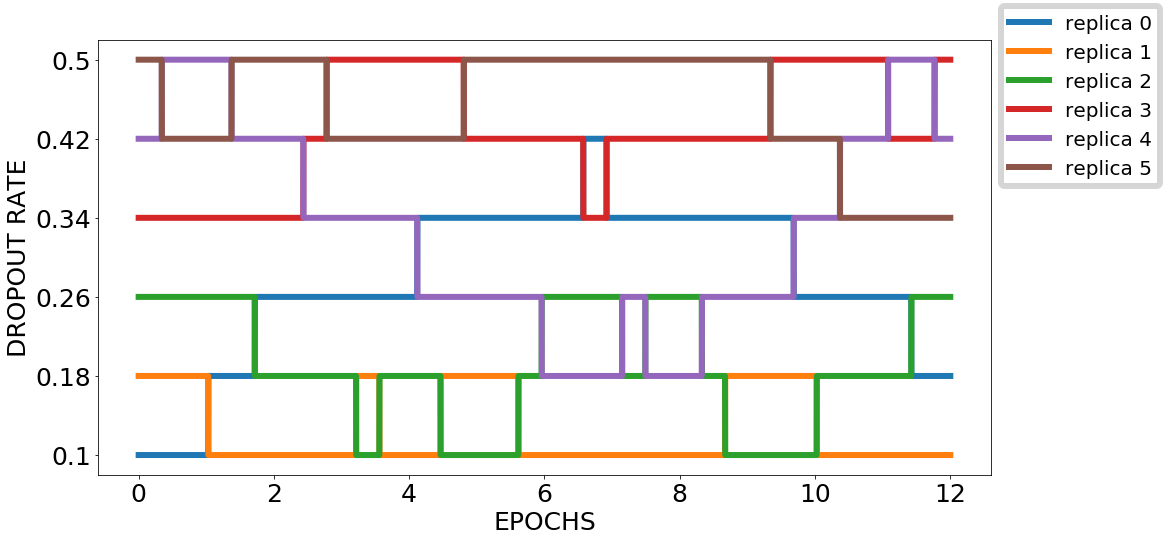

In [7]:

utils.plot_mixing(logs, dropout_list, N_REPLICAS, EPOCHS)